In [1]:
import rich
import torch
import string
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
# import tensorflow_datasets as tfds

from tqdm import tqdm
from torch   import nn
from termcolor import colored

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-11-18 10:34:43.605617: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 10:34:43.626200: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 10:34:43.681206: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 10:34:43.681235: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 10:34:43.681260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# define the device to use
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rich.print(f"Device: [red]{DEVICE}")

Device: cpu

In [3]:
df = pd.read_csv('clean_data.csv')

# split the data
x = df['headline'].values
y = df['is_sarcastic'].values

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    # shuffle = True,
                                                    random_state = 2456)

print(colored("\nDIVIDED SUCCESFULLY...", "green"))


DIVIDED SUCCESFULLY...


In [4]:
unique, counts = np.unique(y_train, return_counts=True)
print("Training set distribution:")
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:")
print(dict(zip(unique, counts)))

Training set distribution:
{0: 10173, 1: 9359}

Test set distribution:
{0: 2559, 1: 2324}


In [5]:
df = pd.read_csv('clean_data.csv')

# split the data
x = df['headline'].values
y = df['is_sarcastic'].values

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 2456)

print(colored("\nDIVIDED SUCCESFULLY...", "green"))


DIVIDED SUCCESFULLY...


In [6]:
unique_words = set()
len_max = 0

for sent in tqdm(x_train):
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 19532/19532 [00:00<00:00, 747099.04it/s]

39
911


In [7]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_test  = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=len_max)
x_test  = pad_sequences(x_test, maxlen=len_max)

print(x_train.shape, x_test.shape)

(19532, 911) (4883, 911)


In [8]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = "auto", 
                               verbose = 1, monitor = "val_acc",
                               patience = 3)
callbacks = [early_stopping]

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(list(unique_words)), 100, 
                              input_length=len_max),
    tf.keras.layers.LSTM(64, dropout = 0.5, recurrent_dropout = 0.5, 
                         return_sequences = True),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss = "binary_crossentropy", 
              optimizer = Adam(learning_rate = 0.004),
              metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 911, 100)          3900      
                                                                 
 lstm_1 (LSTM)               (None, 911, 64)           42240     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 40)                2600      
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                820       
                                                      

In [11]:
history = model.fit(x_train, y_train, 
                    epochs = 5, validation_data = (x_test, y_test), 
                    batch_size = 16, verbose = 1, 
                    callbacks = callbacks)

Epoch 1/5
1221/1221 [==============================] - 1408s 1s/step - loss: 0.6773 - accuracy: 0.5569 - val_loss: 0.6340 - val_accuracy: 0.6895
Epoch 2/5
1221/1221 [==============================] - 1361s 1s/step - loss: 0.6224 - accuracy: 0.6649 - val_loss: 0.5935 - val_accuracy: 0.7033
Epoch 3/5
1221/1221 [==============================] - 1385s 1s/step - loss: 0.6122 - accuracy: 0.6777 - val_loss: 0.6277 - val_accuracy: 0.6783
Epoch 4/5
1221/1221 [==============================] - 1486s 1s/step - loss: 0.6027 - accuracy: 0.6906 - val_loss: 0.6024 - val_accuracy: 0.6768
Epoch 5/5
1221/1221 [==============================] - 1454s 1s/step - loss: 0.6035 - accuracy: 0.6862 - val_loss: 0.5693 - val_accuracy: 0.7076


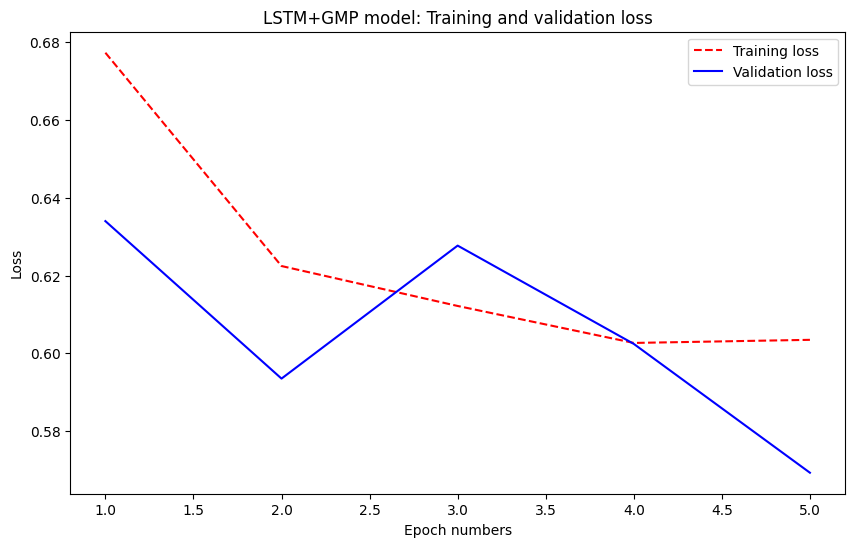

In [20]:
plt.figure(figsize=(10, 6), dpi=100)
epoch_num = range(1, len(history.history["loss"]) + 1)
plt.plot(epoch_num, history.history["loss"], "r--")
plt.plot(epoch_num, history.history["val_loss"], "b-")
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Epoch numbers")
plt.ylabel("Loss")
plt.title('LSTM+GMP model: Training and validation loss')
plt.savefig('LSTM+GMP_loss_plot.png')
plt.show()

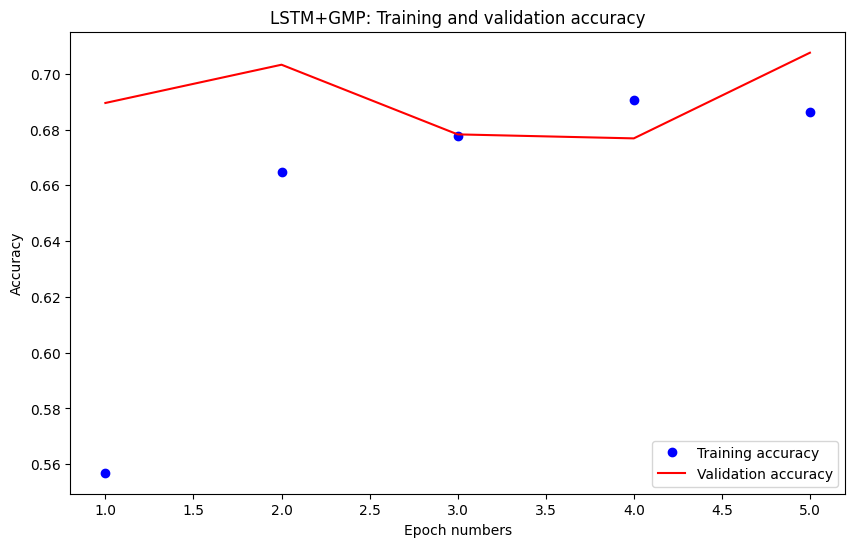

In [21]:
plt.figure(figsize=(10, 6), dpi=100)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel("Epoch numbers")
plt.ylabel("Accuracy")
plt.title('LSTM+GMP: Training and validation accuracy')
plt.legend()
plt.savefig('LSTM+GMP_acc_plot.png')
plt.show()